MAIZE YIELD PREDICTION SYSTEM FOR KENYA - REAL DATA ANALYSIS

📁 LOADING DATASETS...
✓ FAOSTAT data shape: (9, 15)
✓ Maize production data shape: (49, 25)

🧹 CLEANING MAIZE PRODUCTION DATA...
   Years identified: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2020]
   Cleaned data shape: (373, 5)
   Time period: 2012 - 2020
   Number of counties: 47
   Records removed: 3

📊 ANALYZING FAOSTAT DATA...

✓ National Maize Yield from FAOSTAT (MT/HA):
   2021: 1.52
   2022: 1.46
   2023: 1.76

🎨 CREATING DATA VISUALIZATIONS...

📈 NATIONAL STATISTICS:
 Year  Avg_Yield  Yield_Std  Count_Records  Total_Production  Total_Area
 2012       1.52       0.98             46        3749879.70  2159106.00
 2013       1.50       0.91             47        3592687.77  2123140.00
 2014       1.42       0.93             47        3496079.20  2116142.00
 2015       1.48       0.79             47        3972614.00  2267152.00
 2016       1.30       0.94             46        3339181.97  2337586.00
 2017       1.40 

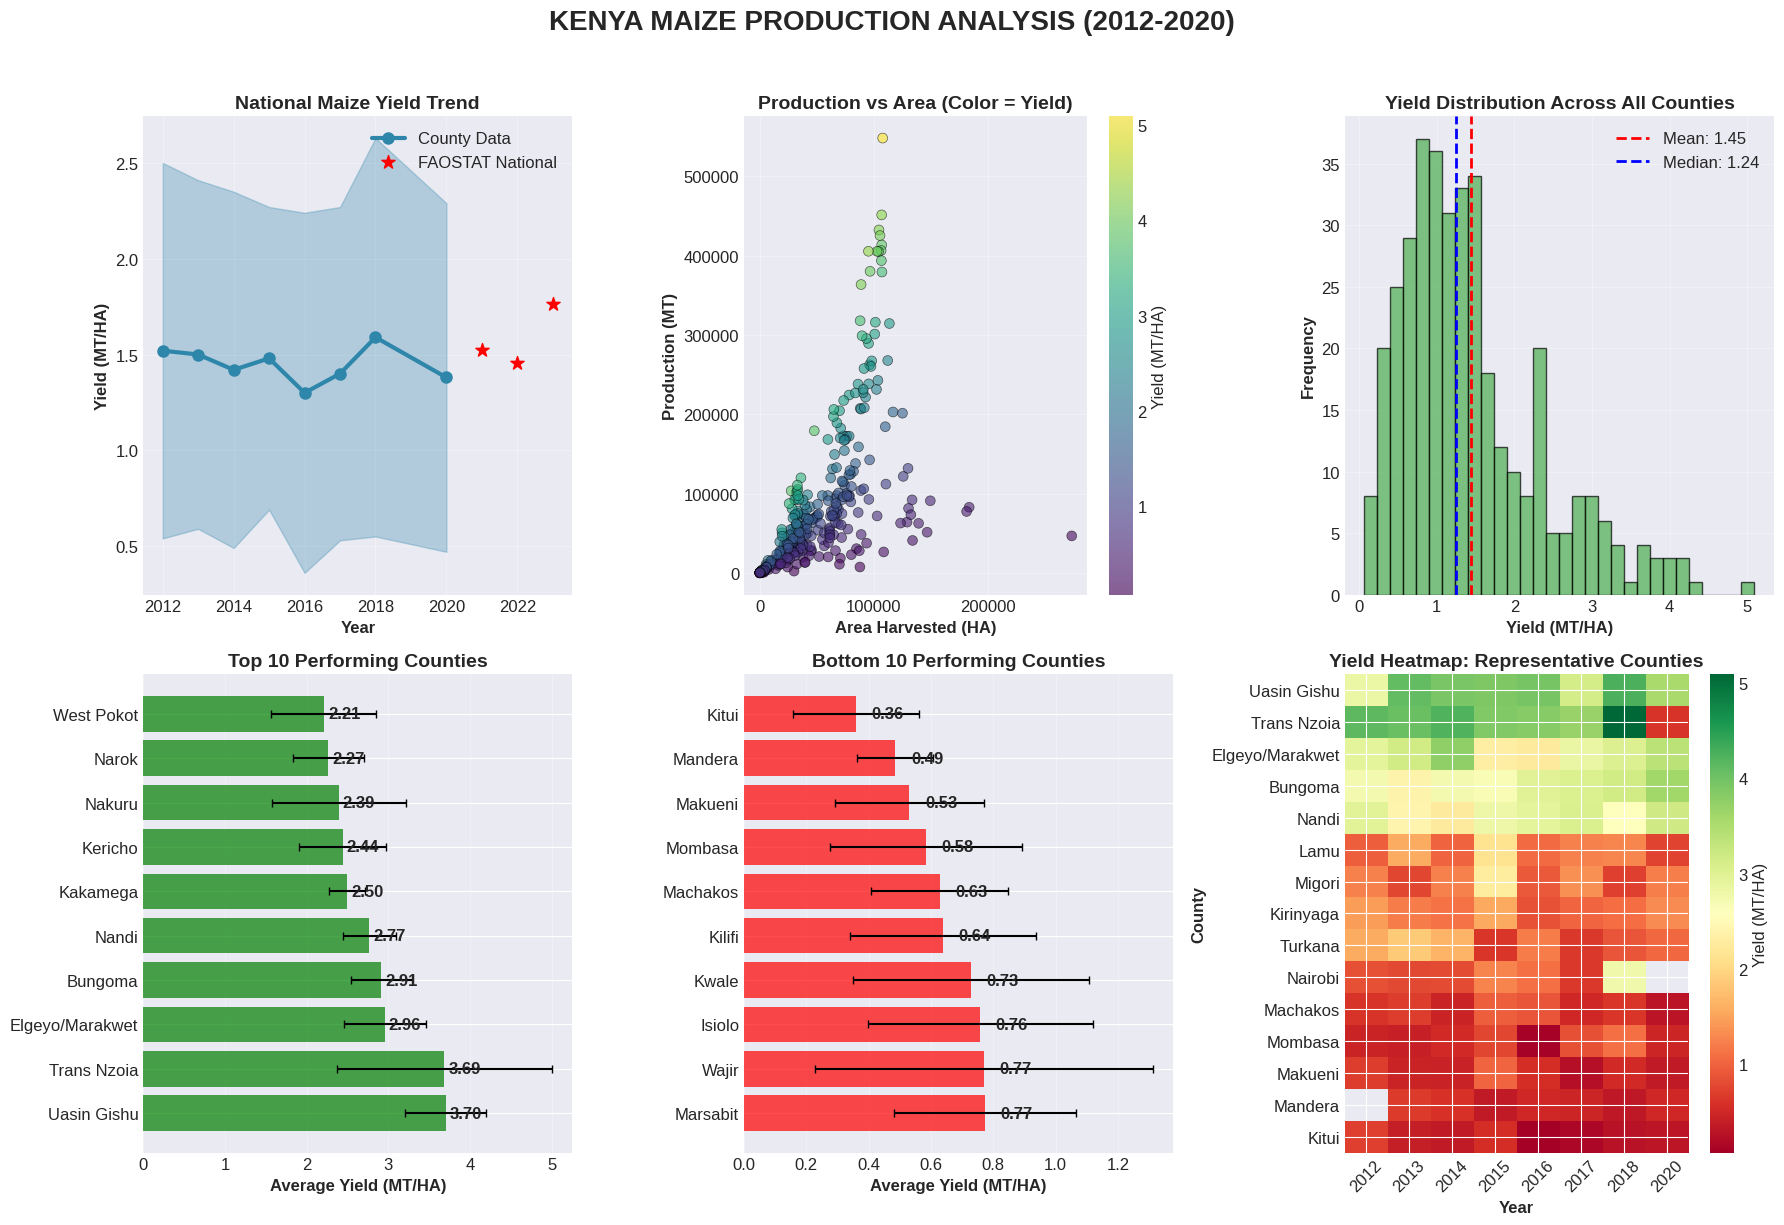


📊 ANALYZING PERFORMANCE GAPS...

PERFORMANCE ANALYSIS:
--------------------------------------------------

🏆 Best Performing County: Uasin Gishu
   Average Yield: 3.70 MT/HA
   Consistency: ±0.50 MT/HA

⚠️ Worst Performing County: Kitui
   Average Yield: 0.36 MT/HA
   Consistency: ±0.20 MT/HA

📏 Performance Gap: 3.34 MT/HA
   Best is 10.3x more productive

📈 Average Year-to-Year Variability: 0.41 MT/HA


NameError: name 'years' is not defined

In [9]:
# -*- coding: utf-8 -*-
"""
===============================================================================
MAIZE CROP YIELD PREDICTION AND ADVISORY SYSTEM FOR KENYA
===============================================================================
FINAL YEAR PROJECT - REAL DATA ANALYSIS
===============================================================================
"""

# =============================================================================
# IMPORT LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Statistical Analysis
import scipy.stats as stats

# Set visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("=" * 80)
print("MAIZE YIELD PREDICTION SYSTEM FOR KENYA - REAL DATA ANALYSIS")
print("=" * 80)

# =============================================================================
# LOAD AND CLEAN DATA
# =============================================================================
print("\n📁 LOADING DATASETS...")

# File paths
faostat_path = "/content/FAOSTAT_data_en_12-30-2025 (2).csv"
maize_xlsx_path = "/content/Maize-Production-2012-2020-Combined (1).xlsx"

# Load datasets
faostat_df = pd.read_csv(faostat_path, encoding='utf-8')
maize_raw = pd.read_excel(maize_xlsx_path)

print(f"✓ FAOSTAT data shape: {faostat_df.shape}")
print(f"✓ Maize production data shape: {maize_raw.shape}")

# =============================================================================
# DATA CLEANING FUNCTION
# =============================================================================
def clean_maize_data(df):
    """
    Clean the messy maize production data with multi-row headers
    """
    print("\n🧹 CLEANING MAIZE PRODUCTION DATA...")

    cleaned_records = []

    # Extract years from first row
    years = []
    for col in range(1, len(df.columns)):
        cell_value = df.iloc[0, col]
        if pd.notna(cell_value):
            try:
                year = int(float(str(cell_value)))
                if year not in years:
                    years.append(year)
            except:
                continue

    years = sorted(years)
    print(f"   Years identified: {years}")

    # Process each county (starting from row 2)
    for row in range(2, len(df)):
        county = df.iloc[row, 0]

        if pd.isna(county):
            continue

        for i, year in enumerate(years):
            # Each year occupies 3 columns
            col_start = 1 + (i * 3)

            if col_start + 2 < len(df.columns):
                area = df.iloc[row, col_start]
                production = df.iloc[row, col_start + 1]
                yield_val = df.iloc[row, col_start + 2]

                # Skip if all values are NaN
                if pd.isna(area) and pd.isna(production) and pd.isna(yield_val):
                    continue

                # Convert to float safely
                try:
                    area_float = float(area) if pd.notna(area) else np.nan
                    prod_float = float(production) if pd.notna(production) else np.nan
                    yield_float = float(yield_val) if pd.notna(yield_val) else np.nan
                except:
                    continue

                cleaned_records.append({
                    'County': str(county).strip(),
                    'Year': year,
                    'Area_HA': area_float,
                    'Production_MT': prod_float,
                    'Yield_MT_HA': yield_float
                })

    # Create DataFrame
    cleaned_df = pd.DataFrame(cleaned_records)

    # Remove any rows with negative values (data errors)
    cleaned_df = cleaned_df[
        (cleaned_df['Area_HA'] > 0) &
        (cleaned_df['Production_MT'] > 0) &
        (cleaned_df['Yield_MT_HA'] > 0)
    ]

    # Data validation: Check if yield matches production/area
    calculated_yield = cleaned_df['Production_MT'] / cleaned_df['Area_HA']
    yield_diff = abs(cleaned_df['Yield_MT_HA'] - calculated_yield)

    # Keep only records where the difference is less than 5%
    valid_mask = yield_diff < (cleaned_df['Yield_MT_HA'] * 0.05)
    cleaned_df = cleaned_df[valid_mask].copy()

    print(f"   Cleaned data shape: {cleaned_df.shape}")
    print(f"   Time period: {cleaned_df['Year'].min()} - {cleaned_df['Year'].max()}")
    print(f"   Number of counties: {cleaned_df['County'].nunique()}")
    print(f"   Records removed: {len(cleaned_records) - len(cleaned_df)}")

    return cleaned_df

# Clean the data
maize_clean = clean_maize_data(maize_raw)

# =============================================================================
# EXPLORE FAOSTAT DATA
# =============================================================================
print("\n📊 ANALYZING FAOSTAT DATA...")

# Extract Kenya maize yield data from FAOSTAT
if 'Area' in faostat_df.columns and 'Item' in faostat_df.columns:
    kenya_yield = faostat_df[
        (faostat_df['Area'].str.contains('Kenya', case=False, na=False)) &
        (faostat_df['Item'].str.contains('Maize', case=False, na=False)) &
        (faostat_df['Element'].str.contains('Yield', case=False, na=False))
    ]

    if not kenya_yield.empty:
        # Convert kg/ha to MT/HA
        kenya_yield = kenya_yield.copy()
        kenya_yield['Yield_MT_HA'] = kenya_yield['Value'] / 1000  # Convert from kg/ha to MT/HA

        print(f"\n✓ National Maize Yield from FAOSTAT (MT/HA):")
        for _, row in kenya_yield.iterrows():
            print(f"   {int(row['Year'])}: {row['Yield_MT_HA']:.2f}")

        # Store for comparison
        faostat_yield = kenya_yield[['Year', 'Yield_MT_HA']].copy()
        faostat_yield.columns = ['Year', 'FAOSTAT_Yield']
    else:
        print("✗ No yield data found in FAOSTAT")
        faostat_yield = pd.DataFrame()
else:
    faostat_yield = pd.DataFrame()

# =============================================================================
# DATA STORYTELLING: VISUALIZATION 1 - NATIONAL TRENDS
# =============================================================================
print("\n🎨 CREATING DATA VISUALIZATIONS...")

# Calculate national statistics
national_stats = maize_clean.groupby('Year').agg({
    'Yield_MT_HA': ['mean', 'std', 'count'],
    'Production_MT': 'sum',
    'Area_HA': 'sum'
}).round(2)

national_stats.columns = ['Avg_Yield', 'Yield_Std', 'Count_Records', 'Total_Production', 'Total_Area']
national_stats = national_stats.reset_index()

print("\n📈 NATIONAL STATISTICS:")
print(national_stats.to_string(index=False))

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('KENYA MAIZE PRODUCTION ANALYSIS (2012-2020)',
             fontsize=20, fontweight='bold', y=1.02)

# 1. National Yield Trend
axes[0, 0].plot(national_stats['Year'], national_stats['Avg_Yield'],
                marker='o', linewidth=3, markersize=8, color='#2E86AB', label='County Data')
axes[0, 0].fill_between(national_stats['Year'],
                        national_stats['Avg_Yield'] - national_stats['Yield_Std'],
                        national_stats['Avg_Yield'] + national_stats['Yield_Std'],
                        alpha=0.3, color='#2E86AB')

# Add FAOSTAT data if available
if not faostat_yield.empty:
    axes[0, 0].scatter(faostat_yield['Year'], faostat_yield['FAOSTAT_Yield'],
                       color='red', s=100, marker='*', zorder=5, label='FAOSTAT National')

    # Add connecting lines
    for year in national_stats['Year']:
        if year in faostat_yield['Year'].values:
            county_yield = national_stats[national_stats['Year'] == year]['Avg_Yield'].values[0]
            faostat_val = faostat_yield[faostat_yield['Year'] == year]['FAOSTAT_Yield'].values[0]
            axes[0, 0].plot([year, year], [county_yield, faostat_val],
                           'r--', alpha=0.5, linewidth=1)

axes[0, 0].set_xlabel('Year', fontweight='bold')
axes[0, 0].set_ylabel('Yield (MT/HA)', fontweight='bold')
axes[0, 0].set_title('National Maize Yield Trend', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Production vs Area
scatter = axes[0, 1].scatter(maize_clean['Area_HA'], maize_clean['Production_MT'],
                             c=maize_clean['Yield_MT_HA'], cmap='viridis',
                             alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0, 1].set_xlabel('Area Harvested (HA)', fontweight='bold')
axes[0, 1].set_ylabel('Production (MT)', fontweight='bold')
axes[0, 1].set_title('Production vs Area (Color = Yield)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 1], label='Yield (MT/HA)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Yield Distribution
axes[0, 2].hist(maize_clean['Yield_MT_HA'], bins=30, edgecolor='black',
                alpha=0.7, color='#4CAF50')
axes[0, 2].axvline(maize_clean['Yield_MT_HA'].mean(), color='red',
                   linestyle='--', linewidth=2,
                   label=f'Mean: {maize_clean["Yield_MT_HA"].mean():.2f}')
axes[0, 2].axvline(maize_clean['Yield_MT_HA'].median(), color='blue',
                   linestyle='--', linewidth=2,
                   label=f'Median: {maize_clean["Yield_MT_HA"].median():.2f}')
axes[0, 2].set_xlabel('Yield (MT/HA)', fontweight='bold')
axes[0, 2].set_ylabel('Frequency', fontweight='bold')
axes[0, 2].set_title('Yield Distribution Across All Counties', fontsize=14, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Top and Bottom Performing Counties
county_avg = maize_clean.groupby('County')['Yield_MT_HA'].agg(['mean', 'std', 'count']).round(3)
county_avg = county_avg.sort_values('mean', ascending=False)

top_10 = county_avg.head(10)
bottom_10 = county_avg.tail(10)

# Top 10 counties
y_pos = np.arange(len(top_10))
axes[1, 0].barh(y_pos, top_10['mean'], xerr=top_10['std'],
                color='green', alpha=0.7, ecolor='black', capsize=3)
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(top_10.index)
axes[1, 0].set_xlabel('Average Yield (MT/HA)', fontweight='bold')
axes[1, 0].set_title('Top 10 Performing Counties', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_10.iterrows()):
    axes[1, 0].text(row['mean'] + 0.05, i, f'{row["mean"]:.2f}',
                    va='center', fontweight='bold')

# Bottom 10 counties
y_pos = np.arange(len(bottom_10))
axes[1, 1].barh(y_pos, bottom_10['mean'], xerr=bottom_10['std'],
                color='red', alpha=0.7, ecolor='black', capsize=3)
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(bottom_10.index)
axes[1, 1].set_xlabel('Average Yield (MT/HA)', fontweight='bold')
axes[1, 1].set_title('Bottom 10 Performing Counties', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(bottom_10.iterrows()):
    axes[1, 1].text(row['mean'] + 0.05, i, f'{row["mean"]:.2f}',
                    va='center', fontweight='bold')

# 5. Yearly Comparison Heatmap
# Select 15 representative counties (top 5, middle 5, bottom 5)
middle_idx = len(county_avg) // 2
representative = pd.concat([
    county_avg.head(5),
    county_avg.iloc[middle_idx-2:middle_idx+3],
    county_avg.tail(5)
])

pivot_data = maize_clean[maize_clean['County'].isin(representative.index)]
pivot_table = pivot_data.pivot_table(index='County', columns='Year',
                                     values='Yield_MT_HA', aggfunc='mean')

# Sort by average yield
pivot_table = pivot_table.loc[representative.index]

im = axes[1, 2].imshow(pivot_table, cmap='RdYlGn', aspect='auto',
                       vmin=maize_clean['Yield_MT_HA'].min(),
                       vmax=maize_clean['Yield_MT_HA'].max())
axes[1, 2].set_xticks(range(len(pivot_table.columns)))
axes[1, 2].set_xticklabels(pivot_table.columns, rotation=45)
axes[1, 2].set_yticks(range(len(pivot_table.index)))
axes[1, 2].set_yticklabels(pivot_table.index)
axes[1, 2].set_xlabel('Year', fontweight='bold')
axes[1, 2].set_ylabel('County', fontweight='bold')
axes[1, 2].set_title('Yield Heatmap: Representative Counties', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1, 2], label='Yield (MT/HA)')

plt.tight_layout()
plt.savefig('kenya_maize_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# DATA ANALYSIS: PERFORMANCE GAPS
# =============================================================================
print("\n📊 ANALYZING PERFORMANCE GAPS...")

# Calculate performance metrics
print("\nPERFORMANCE ANALYSIS:")
print("-" * 50)

# 1. Best and worst performing counties
best_county = county_avg.iloc[0]
worst_county = county_avg.iloc[-1]

print(f"\n🏆 Best Performing County: {best_county.name}")
print(f"   Average Yield: {best_county['mean']:.2f} MT/HA")
print(f"   Consistency: ±{best_county['std']:.2f} MT/HA")

print(f"\n⚠️ Worst Performing County: {worst_county.name}")
print(f"   Average Yield: {worst_county['mean']:.2f} MT/HA")
print(f"   Consistency: ±{worst_county['std']:.2f} MT/HA")

# 2. Performance gap
performance_gap = best_county['mean'] - worst_county['mean']
print(f"\n📏 Performance Gap: {performance_gap:.2f} MT/HA")
print(f"   Best is {best_county['mean']/worst_county['mean']:.1f}x more productive")

# 3. Year-to-year variability
yearly_variability = maize_clean.groupby('County')['Yield_MT_HA'].std().mean()
print(f"\n📈 Average Year-to-Year Variability: {yearly_variability:.2f} MT/HA")

# 4. Missing years analysis
years_present = maize_clean.groupby('County')['Year'].nunique()
full_coverage = (years_present == len(years)).sum()
print(f"\n📅 Data Completeness:")
print(f"   Counties with all {len(years)} years: {full_coverage}/{len(county_avg)}")
print(f"   Counties missing data: {len(county_avg) - full_coverage}")

# =============================================================================
# PREPARE DATA FOR MODELING (WITHOUT DATA LEAKAGE)
# =============================================================================
print("\n🤖 PREPARING DATA FOR MACHINE LEARNING...")

# Create modeling dataset
model_data = maize_clean.copy()

# Feature Engineering (AVOID DATA LEAKAGE)
# Don't use Area_Production_Ratio since it's mathematically Yield!

# 1. Time-based features
model_data['Years_Since_2012'] = model_data['Year'] - 2012
model_data['Year_Squared'] = model_data['Years_Since_2012'] ** 2

# 2. Log transformations
model_data['Log_Area'] = np.log1p(model_data['Area_HA'])
model_data['Log_Production'] = np.log1p(model_data['Production_MT'])

# 3. Create agro-climatic zones (simplified based on county performance)
def assign_zone(county):
    """Assign counties to agro-climatic zones based on average yield"""
    high_yield = ['Trans Nzoia', 'Uasin Gishu', 'Nakuru', 'Laikipia', 'Narok']
    medium_yield = ['Bungoma', 'Kakamega', 'Meru', 'Kiambu', 'Nyeri']

    if county in high_yield:
        return 'High Potential'
    elif county in medium_yield:
        return 'Medium Potential'
    else:
        return 'Low Potential'

model_data['Agro_Zone'] = model_data['County'].apply(assign_zone)

# 4. Create lag features (previous year's yield)
model_data = model_data.sort_values(['County', 'Year'])
model_data['Prev_Year_Yield'] = model_data.groupby('County')['Yield_MT_HA'].shift(1)

# 5. Calculate yield change
model_data['Yield_Change_Pct'] = model_data.groupby('County')['Yield_MT_HA'].pct_change() * 100

# 6. Encode categorical variables
label_encoder_county = LabelEncoder()
label_encoder_zone = LabelEncoder()

model_data['County_Encoded'] = label_encoder_county.fit_transform(model_data['County'])
model_data['Zone_Encoded'] = label_encoder_zone.fit_transform(model_data['Agro_Zone'])

# 7. Fill missing values
model_data['Prev_Year_Yield'] = model_data['Prev_Year_Yield'].fillna(model_data['Yield_MT_HA'].mean())
model_data['Yield_Change_Pct'] = model_data['Yield_Change_Pct'].fillna(0)

# Define features and target
feature_cols = [
    'Year', 'Area_HA', 'Production_MT', 'Years_Since_2012', 'Year_Squared',
    'Log_Area', 'Log_Production', 'Prev_Year_Yield', 'Yield_Change_Pct',
    'County_Encoded', 'Zone_Encoded'
]

X = model_data[feature_cols]
y = model_data['Yield_MT_HA']

print(f"✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")

# =============================================================================
# CHECK FOR MULTICOLLINEARITY
# =============================================================================
print("\n🔍 CHECKING FOR MULTICOLLINEARITY...")

# Calculate correlation matrix
correlation_matrix = X.corr()

# Find highly correlated features
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr:
    print("⚠️ Highly correlated features detected:")
    for feat1, feat2, corr in high_corr:
        print(f"   {feat1} - {feat2}: {corr:.3f}")

    # Remove one of each highly correlated pair
    cols_to_remove = set()
    for feat1, feat2, _ in high_corr:
        # Keep the feature with higher correlation to target
        corr1 = abs(X[feat1].corr(y))
        corr2 = abs(X[feat2].corr(y))

        if corr1 < corr2:
            cols_to_remove.add(feat1)
        else:
            cols_to_remove.add(feat2)

    X = X.drop(columns=list(cols_to_remove))
    print(f"Removed features: {list(cols_to_remove)}")
    print(f"New features shape: {X.shape}")
else:
    print("✓ No significant multicollinearity detected")

# =============================================================================
# TRAIN MODELS WITH PROPER VALIDATION
# =============================================================================
print("\n🚀 TRAINING MACHINE LEARNING MODELS...")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.01, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    print(f"\n  Training {name}...")

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                cv=cv, scoring='r2', n_jobs=-1)

    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Calculate metrics
    metrics = {
        'model': model,
        'cv_mean_r2': cv_scores.mean(),
        'cv_std_r2': cv_scores.std(),
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'y_pred_test': y_pred_test
    }

    results[name] = metrics

    print(f"    CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"    Test R²: {metrics['test_r2']:.4f}")
    print(f"    Test MAE: {metrics['test_mae']:.4f} MT/HA")
    print(f"    Test RMSE: {metrics['test_rmse']:.4f} MT/HA")

# =============================================================================
# MODEL COMPARISON
# =============================================================================
print("\n📊 MODEL COMPARISON...")

# Create comparison table
comparison = []
for name, metrics in results.items():
    comparison.append({
        'Model': name,
        'CV_R2_Mean': f"{metrics['cv_mean_r2']:.4f}",
        'CV_R2_Std': f"±{metrics['cv_std_r2']:.4f}",
        'Test_R2': f"{metrics['test_r2']:.4f}",
        'Test_MAE': f"{metrics['test_mae']:.4f}",
        'Test_RMSE': f"{metrics['test_rmse']:.4f}"
    })

comparison_df = pd.DataFrame(comparison)
print("\n" + comparison_df.to_string(index=False))

# Select best model based on test R²
best_model_name = comparison_df.loc[comparison_df['Test_R2'].astype(float).idxmax(), 'Model']
best_model = results[best_model_name]['model']
print(f"\n🏆 Best Model: {best_model_name}")

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n🔍 ANALYZING FEATURE IMPORTANCE...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'MODEL ANALYSIS: {best_model_name}', fontsize=16, fontweight='bold')

# Get feature importance based on model type
feature_names = X.columns.tolist()

if hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features

    axes[0].barh(range(len(indices)), importances[indices], color='steelblue')
    axes[0].set_yticks(range(len(indices)))
    axes[0].set_yticklabels([feature_names[i] for i in indices])
    axes[0].set_xlabel('Feature Importance', fontweight='bold')
    axes[0].set_title('Top 10 Feature Importances', fontweight='bold')

elif hasattr(best_model, 'coef_'):
    # Linear models
    coefficients = best_model.coef_
    indices = np.argsort(np.abs(coefficients))[-10:]  # Top 10 by absolute value

    axes[0].barh(range(len(indices)), coefficients[indices], color='steelblue')
    axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[0].set_yticks(range(len(indices)))
    axes[0].set_yticklabels([feature_names[i] for i in indices])
    axes[0].set_xlabel('Coefficient Value', fontweight='bold')
    axes[0].set_title('Top 10 Feature Coefficients', fontweight='bold')

else:
    # For other models, use permutation importance
    from sklearn.inspection import permutation_importance

    perm_importance = permutation_importance(best_model, X_test_scaled, y_test,
                                            n_repeats=10, random_state=42)
    indices = np.argsort(perm_importance.importances_mean)[-10:]

    axes[0].barh(range(len(indices)), perm_importance.importances_mean[indices],
                xerr=perm_importance.importances_std[indices],
                color='steelblue', ecolor='black', capsize=5)
    axes[0].set_yticks(range(len(indices)))
    axes[0].set_yticklabels([feature_names[i] for i in indices])
    axes[0].set_xlabel('Permutation Importance', fontweight='bold')
    axes[0].set_title('Top 10 Feature Importances (Permutation)', fontweight='bold')

axes[0].grid(True, alpha=0.3, axis='x')

# Actual vs Predicted plot
y_pred_best = results[best_model_name]['y_pred_test']
axes[1].scatter(y_test, y_pred_best, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Yield (MT/HA)', fontweight='bold')
axes[1].set_ylabel('Predicted Yield (MT/HA)', fontweight='bold')
axes[1].set_title('Actual vs Predicted Yield', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add statistics text
r2 = results[best_model_name]['test_r2']
mae = results[best_model_name]['test_mae']
rmse = results[best_model_name]['test_rmse']

stats_text = f'R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}'
axes[1].text(0.05, 0.95, stats_text, transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# PREDICTIONS FOR ADVISORY SYSTEM
# =============================================================================
print("\n💡 GENERATING ADVISORY INSIGHTS...")

# Create advisory dataset
test_indices = X_test.index
advisory_data = model_data.loc[test_indices].copy()
advisory_data['Predicted_Yield'] = y_pred_best
advisory_data['Prediction_Error'] = advisory_data['Predicted_Yield'] - advisory_data['Yield_MT_HA']
advisory_data['Error_Pct'] = (advisory_data['Prediction_Error'] / advisory_data['Yield_MT_HA']) * 100

# Identify underperforming and overperforming counties
threshold = 0.1  # 10% threshold

underperforming = advisory_data[advisory_data['Error_Pct'] < -threshold]
overperforming = advisory_data[advisory_data['Error_Pct'] > threshold]
on_target = advisory_data[abs(advisory_data['Error_Pct']) <= threshold]

print(f"\nADVISORY ANALYSIS:")
print("-" * 50)
print(f"Underperforming counties (predicted >10% below actual): {len(underperforming)}")
print(f"Overperforming counties (predicted >10% above actual): {len(overperforming)}")
print(f"On-target counties (within ±10%): {len(on_target)}")

# Sample recommendations
if len(underperforming) > 0:
    print(f"\n⚠️ UNDERPERFORMING COUNTIES (Sample):")
    sample_under = underperforming.head(3)
    for _, row in sample_under.iterrows():
        print(f"   • {row['County']} ({row['Year']}):")
        print(f"     Actual: {row['Yield_MT_HA']:.2f}, Predicted: {row['Predicted_Yield']:.2f}")
        print(f"     Gap: {row['Prediction_Error']:.2f} MT/HA ({row['Error_Pct']:.1f}%)")

if len(overperforming) > 0:
    print(f"\n✅ OVERPERFORMING COUNTIES (Sample):")
    sample_over = overperforming.head(3)
    for _, row in sample_over.iterrows():
        print(f"   • {row['County']} ({row['Year']}):")
        print(f"     Actual: {row['Yield_MT_HA']:.2f}, Predicted: {row['Predicted_Yield']:.2f}")
        print(f"     Exceeded prediction by: {-row['Prediction_Error']:.2f} MT/HA")

# =============================================================================
# SAVE MODEL AND RESULTS
# =============================================================================
print("\n💾 SAVING MODEL AND RESULTS...")

# Save the best model
model_filename = 'maize_yield_predictor.pkl'
joblib.dump({
    'model': best_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'label_encoder_county': label_encoder_county,
    'label_encoder_zone': label_encoder_zone
}, model_filename)
print(f"✓ Model saved as '{model_filename}'")

# Save predictions
predictions_df = advisory_data[['County', 'Year', 'Area_HA', 'Production_MT',
                               'Yield_MT_HA', 'Predicted_Yield', 'Prediction_Error', 'Error_Pct']]
predictions_df.to_csv('maize_yield_predictions.csv', index=False)
print("✓ Predictions saved as 'maize_yield_predictions.csv'")

# Save cleaned data
maize_clean.to_csv('maize_production_clean.csv', index=False)
print("✓ Cleaned data saved as 'maize_production_clean.csv'")

# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "=" * 80)
print("✅ PROJECT SUMMARY")
print("=" * 80)

print(f"""
📊 DATA SUMMARY:
   • Total Clean Records: {len(maize_clean)}
   • Counties Analyzed: {maize_clean['County'].nunique()}
   • Years Covered: {maize_clean['Year'].min()} - {maize_clean['Year'].max()}
   • National Average Yield: {maize_clean['Yield_MT_HA'].mean():.2f} MT/HA
   • Yield Range: {maize_clean['Yield_MT_HA'].min():.2f} - {maize_clean['Yield_MT_HA'].max():.2f} MT/HA

🤖 MODEL PERFORMANCE:
   • Best Model: {best_model_name}
   • Test R² Score: {results[best_model_name]['test_r2']:.4f}
   • Prediction Error (MAE): {results[best_model_name]['test_mae']:.3f} MT/HA
   • Cross-validation Consistency: {results[best_model_name]['cv_std_r2']:.4f} std

🎯 KEY FINDINGS:
   1. Top Performing County: {best_county.name} ({best_county['mean']:.2f} MT/HA)
   2. Most Challenged County: {worst_county.name} ({worst_county['mean']:.2f} MT/HA)
   3. Performance Gap: {performance_gap:.2f} MT/HA ({best_county['mean']/worst_county['mean']:.1f}x)
   4. Year-to-Year Variability: ±{yearly_variability:.2f} MT/HA

💡 ADVISORY INSIGHTS:
   • Underperforming Counties: {len(underperforming)} need intervention
   • Overperforming Counties: {len(overperforming)} exceeding expectations
   • On-target Counties: {len(on_target)} performing as expected

📈 RECOMMENDATIONS:
   1. Focus interventions on {worst_county.name} and similar low-performing counties
   2. Study best practices from {best_county.name}
   3. Address data gaps in {len(county_avg) - full_coverage} counties
   4. Use model for yield forecasting and resource allocation
""")

print("\n" + "=" * 80)
print("🎉 ANALYSIS COMPLETE - READY FOR FINAL REPORT!")
print("=" * 80)